# Malicious or Benign Website Classification

In this project I classify websites as malicious or benign use data from Urcuqui, C., Navarro, A., Osorio, J., & Garcıa, M. (2017). 

First, I clean the data, engineer several features, and visualize several variables.

I then use four machine learning algorithms: random forests, k-nearest neighbors classification, and support vector classification. 
I find that random forest classification is consistently the best classification algorithm for this task, with an accuracy score consistently greater than 0.95. This is followed closely by the support vector classification.




 
 
  
   
Data from:

Urcuqui, C., Navarro, A., Osorio, J., & Garcıa, M. (2017). Machine Learning Classifiers to Detect Malicious Websites. CEUR Workshop Proceedings. Vol 1950, 14-17.

Note: The interactive maps do not render in GitHub. I uploaded images of the maps to the repository.

In [570]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_csv("dataset.csv")

In [571]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
URL                          1781 non-null object
URL_LENGTH                   1781 non-null int64
NUMBER_SPECIAL_CHARACTERS    1781 non-null int64
CHARSET                      1781 non-null object
SERVER                       1780 non-null object
CONTENT_LENGTH               969 non-null float64
WHOIS_COUNTRY                1781 non-null object
WHOIS_STATEPRO               1781 non-null object
WHOIS_REGDATE                1781 non-null object
WHOIS_UPDATED_DATE           1781 non-null object
TCP_CONVERSATION_EXCHANGE    1781 non-null int64
DIST_REMOTE_TCP_PORT         1781 non-null int64
REMOTE_IPS                   1781 non-null int64
APP_BYTES                    1781 non-null int64
SOURCE_APP_PACKETS           1781 non-null int64
REMOTE_APP_PACKETS           1781 non-null int64
SOURCE_APP_BYTES             1781 non-null int64
REMOTE_APP_BYTES             1781 non-null int64
APP

In [572]:
"""
Creating dummy variables for CHARSET and WHOIS_COUNTRY

"""

df['CHARSET'] = list(map(lambda x: x.lower(),df['CHARSET']))
df = pd.concat([df,pd.get_dummies(df["CHARSET"],drop_first=True,prefix="CHARSET")],axis=1)
df.drop(columns='CHARSET',inplace=True)
df = pd.concat([df,pd.get_dummies(df["WHOIS_COUNTRY"],drop_first=True,prefix="COUNTRY: ")],axis=1)

# consolidating WHOIS_COUNTRY dummies
df["COUNTRY: _US"] += df["COUNTRY: _us"]
df.drop(columns="COUNTRY: _us",inplace=True)
df["COUNTRY: _RU"] += df["COUNTRY: _ru"]
df.drop(columns="COUNTRY: _ru",inplace=True)
df["COUNTRY: _SE"] += df["COUNTRY: _se"]
df.drop(columns="COUNTRY: _se",inplace=True)
df["COUNTRY: _UK"] += df["COUNTRY: _United Kingdom"] + df["COUNTRY: _[u'GB'; u'UK']"]
df.drop(columns=["COUNTRY: _United Kingdom","COUNTRY: _[u'GB'; u'UK']"],inplace=True)
df.rename(columns={"COUNTRY: _Cyprus":"COUNTRY: _CY"},inplace=True)

In [573]:
"""
Creating WHOIS_STATEPRO dummies: US census region dummies for US states and dummy variables for foreign entries

"""

# determining which entries are US states
foreign_bool = df["COUNTRY: _US"] == 0
state = []
for i in range(len(df['WHOIS_STATEPRO'])):
    if foreign_bool[i]:
        state.append('NotUS')
    else:
        state.append(df["WHOIS_STATEPRO"][i])

# importing state codes to deal with instances of "ny", "New York", and "NY" and the like
state_codes = pd.read_html('https://www.infoplease.com/state-abbreviations-and-state-postal-codes')[0]
region_codes = pd.read_html('https://www.cdc.gov/std/stats16/census.htm')[0]

# making these code tables uppercase
for col in state_codes.columns:
    state_codes[col] = list(map(lambda x: x.upper(),state_codes[col]))
for col in region_codes.columns:
    region_codes[col] = list(map(lambda x: str(x).upper(),region_codes[col]))    

# putting all US states in the form of "NY"
state_codes_ref = state_codes.set_index("Postal Code")
state_clean = []
for i in range(len(state)):
    if state[i].upper() in list(state_codes["Postal Code"]):
        state_clean.append(state_codes_ref.loc[state[i].upper()]['State/District'])
    elif state[i].upper() == "UTR":
        state_clean.append(np.NaN)
    else:
        state_clean.append(state[i].upper())

# determining US Census region based on state code and plugging in foreign WHOIS_STATEPRO value if not in the US
regions = []        
for i in range(len(state_clean)):
    reg_found = False
    if state_clean[i] == 'NOTUS':
        regions.append(df["WHOIS_STATEPRO"][i].upper())
        reg_found = True
    else:
        for j in range(len(region_codes.columns)):
            if state_clean[i] in list(region_codes[region_codes.columns[j]]):
                regions.append(region_codes.columns[j])
                reg_found = True
    if not reg_found:
        regions.append(np.NaN)
        
# creating region dummies    
df = pd.concat([df,pd.Series(state_clean,name="State")],axis=1)
df = pd.concat([df,pd.get_dummies(regions,drop_first=True,prefix="REGION")],axis=1)

In [574]:
"""
Creating dummy variables for SERVER column

"""

def server_cleaner(server):    
    """
    takes in an entry in the SERVER column and returns the initial value or the value 
    of a common server type if possible 
    
    ex:
    takes in: nginx/1.8.1                                                                                                      
    or: nginx/1.10.1   
    and returns: nginx
    """
    for kind in ["apache","nginx","microsoft","codfw.wmnet"]:
        server = str(server).lower().strip()
        if kind in server:
            return kind
    return server

#mapping server_cleaner to SERVER column
servers = pd.Series(list((map(server_cleaner,df["SERVER"]))))
#creating a series stating whether or not a server type shoes up less than 30 times
server_count = servers.value_counts()
uncommon = server_count < 30

other_bool = []
for i in servers:
    if uncommon.loc[i]:
        other_bool.append(True)
    else:
        other_bool.append(False)

# creating dummy variables for server types, including an "other" category for servers types that appear less than 30 times
servers_clean = []
for i in range(len(servers)):
    if other_bool[i]:
        servers_clean.append("other")
    else:
        servers_clean.append(servers[i])

df = pd.concat([df,pd.get_dummies(servers_clean,drop_first = True,prefix='SERVER: ')],axis=1)

In [575]:
"""
Creating a Time Since Reg variable: the number of days since the server was registered

Creating a Last Update variable: the number of days since the last update

"""
# converting WHOIS_REGDATE and WHOIS_UPDATED_DATE to Timestamp objects
df["WHOIS_REGDATE"]=pd.to_datetime(df["WHOIS_REGDATE"],errors='coerce')
df["WHOIS_UPDATED_DATE"]=pd.to_datetime(df['WHOIS_UPDATED_DATE'],errors='coerce')
# creating today's date column
df['Today'] = pd.to_datetime('today')
# subtracting update and registration dates from todays date
df["Last Update"]=df['Today'].sub(df['WHOIS_UPDATED_DATE'], axis=0)
df["Time Since Reg"]=df['Today'].sub(df['WHOIS_REGDATE'], axis=0)
# replacing NaT values with the column mean
df["Last Update"] = df["Last Update"].fillna(value=df["Last Update"].mean())
df["Time Since Reg"] = df["Time Since Reg"].fillna(value=df["Time Since Reg"].mean())
# converting columns to float
df["Last Update"] /= np.timedelta64(1, 'D')
df["Time Since Reg"] /= np.timedelta64(1, 'D')


In [576]:
"""
Fillilng NaN values of CONTENT_LENGTH with the column mean

"""

df["CONTENT_LENGTH"] = df["CONTENT_LENGTH"].fillna(value=df["CONTENT_LENGTH"].mean())


In [577]:
"""
Prepping data for analysis

"""

from sklearn.preprocessing import StandardScaler
# scaling quantitative 
df.drop(columns=["URL","SERVER","WHOIS_UPDATED_DATE","WHOIS_STATEPRO","WHOIS_REGDATE",'Today',"WHOIS_COUNTRY","State"],
        inplace=True)
df.dropna(axis=0,inplace=True)
scaler = StandardScaler()
scale_cols = ['URL_LENGTH',
 'NUMBER_SPECIAL_CHARACTERS',
 'CONTENT_LENGTH',
 'TCP_CONVERSATION_EXCHANGE',
 'DIST_REMOTE_TCP_PORT',
 'REMOTE_IPS',
 'APP_BYTES',
 'SOURCE_APP_PACKETS',
 'REMOTE_APP_PACKETS',
 'SOURCE_APP_BYTES',
 'REMOTE_APP_BYTES',
 'APP_PACKETS',
 'DNS_QUERY_TIMES']

scaler.fit(df[scale_cols])
scaled_features = scaler.transform(df[scale_cols])

scaled_features = pd.DataFrame(scaled_features,columns=scale_cols)

df = pd.concat([scaled_features,df.drop(columns=scale_cols,axis=1)],axis=1)
df.dropna(axis=0,inplace=True)



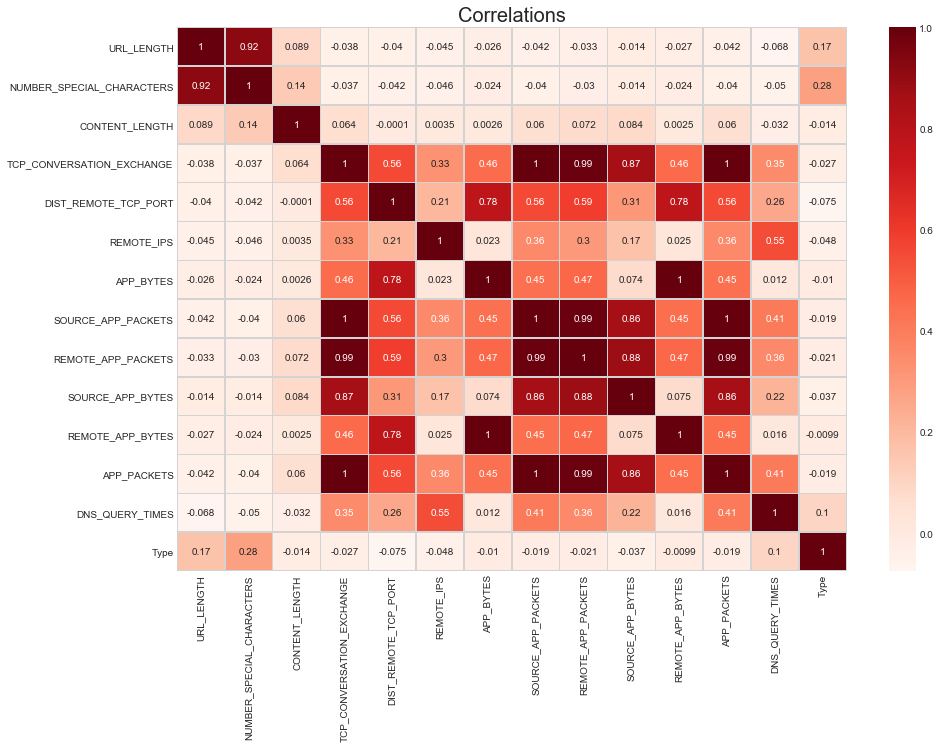

In [578]:
"""
Visualizing correlations with a heatmap

"""
# creating viz dataframe to hold data of interest for visualizatin
viz = pd.concat([df.iloc[:,:13],df['Type']],axis=1)

plt.figure(figsize=(15,10))
plt.title("Correlations",{'fontsize':20})
sns.set_style("darkgrid")
sns.heatmap(viz.corr(),cmap='Reds',annot=True,linewidths=.5,linecolor='lightgray')

Text(0,0.5,'URL Length')

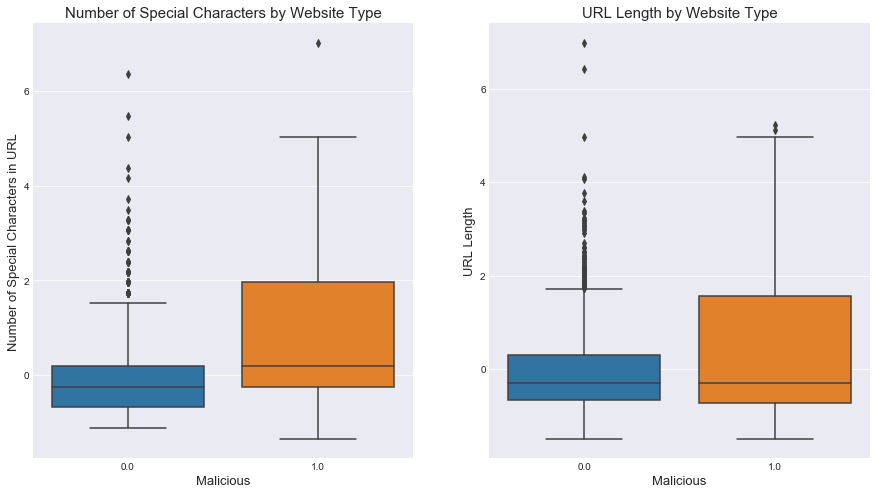

In [579]:
"""
Boxplots of URL_LENGTH and NUMBER_SPECIAL_CHARACTERS by malicious or benign

"""

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
# special characters
sns.boxplot(x='Type',y="NUMBER_SPECIAL_CHARACTERS",data=viz,ax=axes[0])
axes[0].set_title("Number of Special Characters by Website Type",{'fontsize':15})
axes[0].set_xlabel('Malicious',{'fontsize':13})
axes[0].set_ylabel('Number of Special Characters in URL',{'fontsize':13})
# url length
sns.boxplot(x='Type',y="URL_LENGTH",data=viz,ax=axes[1])
axes[1].set_title("URL Length by Website Type",{'fontsize':15})
axes[1].set_xlabel('Malicious',{'fontsize':13})
axes[1].set_ylabel('URL Length',{'fontsize':13})

In [580]:
"""
Mapping each states' proportion of malicious websites

"""

import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# getting malicious website proportino for each state
vizg = pd.concat([viz,pd.Series(state_clean,name="State")],axis=1)
state_prop = vizg.groupby("State").sum()['Type'] / vizg.groupby("State").count()['Type']
state_prop = pd.DataFrame(state_prop)
state_prop.reset_index(inplace=True)
state_prop.rename(columns={"Type":"Malicious_Proportion"},inplace=True)
# creating text column
state_prop = state_prop.merge(state_codes,left_on="State",right_on="State/District")
state_prop = state_prop.merge(pd.DataFrame(vizg.groupby("State").count()["Type"]),on="State")
state_prop['Text'] = list(map(lambda x: "Website Count: " + str(x),state_prop["Type"]))

data = dict(type = 'choropleth',
            locations = state_prop["Postal Code"],
            locationmode = 'USA-states',
            colorscale= 'Gray',
            text = state_prop["Text"],
            z=np.around(state_prop["Malicious_Proportion"],decimals=2),
            colorbar = {'title':'Proportion'})
layout = dict(title = "States' Proportions of Malicious Websites",geo = {'scope':'usa'})
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

The interactive maps do not render in GitHub. I've uploaded images of the maps to the repository.

In [581]:
"""
Mapping each country's porportion of malicious websites

"""

# getting malicious website proportion and count per country
country = df[df.columns[20:63]]
country['Type'] = df["Type"]
country.drop(columns = "COUNTRY: _None",inplace=True)
country_graph = pd.DataFrame(np.around(country.groupby("Type").sum().loc[1.0] / 
                                       (country.groupby("Type").sum().loc[1.0] + country.groupby("Type").sum().loc[0.0]),decimals=2))
# creating text column
country_graph['Count'] = country.groupby("Type").sum().loc[1.0] + country.groupby("Type").sum().loc[0.0]
country_graph['Text'] = list(map(lambda x: "Website Count: " + str(int(x)),country_graph["Count"]))
# converting row names to ISO-3 country codes
country_graph.reset_index(inplace=True)
country_graph["index"] = list(map(lambda x: x[10:],country_graph["index"]))
country_codes = pd.read_html("https://www.worldatlas.com/aatlas/ctycodes.htm")[0]
country_graph = pd.merge(country_graph,country_codes,left_on ="index",right_on=1)


data = dict(
        type = 'choropleth',
        locations = country_graph[2],
        locationmode = "",
        z = country_graph['0_x'],
        text = country_graph["Text"],
        colorbar = {'title' : 'Proportion'},
      ) 
layout = dict(
    title = "Countries' Proportions of Malicious Websites",
    geo = dict(
        showframe = False,
        projection = {'type':'Mercator'}
    )
)

choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

c:\users\kincaid youman\udemy\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\kincaid youman\udemy\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [582]:
"""
Prepping for classification

"""

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# splitting into training and testing data
X = df.drop(columns="Type",axis=1)
y = df["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Machine Learning Classification

In [583]:
"""
Random forest classification

"""

from sklearn.ensemble import RandomForestClassifier
rcf = RandomForestClassifier(n_estimators=200)
rcf.fit(X_train,y_train)
rcf_pred = rcf.predict(X_test)
print("Confusion Matrix\n")
print(pd.DataFrame(confusion_matrix(y_test,rcf_pred),index=["Actual: No","Actual: Yes"],columns=["Predicted: No","Predicted: Yes"]))
print("\nClassification Report\n")
print(classification_report(y_test,rcf_pred))
print("Accuracy Score\n")
print(accuracy_score(y_test,rcf_pred))

Confusion Matrix

             Predicted: No  Predicted: Yes
Actual: No             474               3
Actual: Yes             14              43

Classification Report

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       477
        1.0       0.93      0.75      0.83        57

avg / total       0.97      0.97      0.97       534

Accuracy Score

0.9681647940074907


Text(0,0.5,'Error Rate')

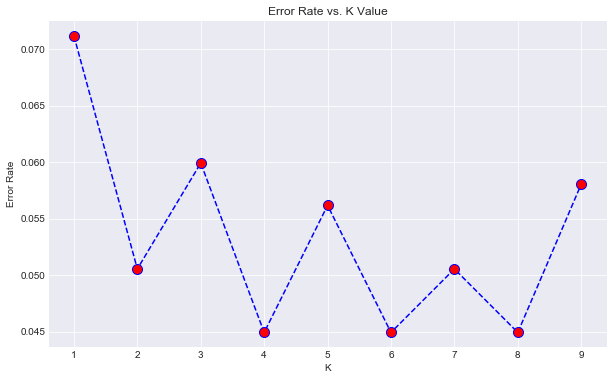

In [584]:
"""
K-nearest neighbors classification

"""

from sklearn.neighbors import KNeighborsClassifier
# finding error rates for a range of k values
error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
# plotting error rates vs. k-values
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [588]:
# KNN classification
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
print("Confusion Matrix\n")
print(pd.DataFrame(confusion_matrix(y_test,knn_pred),index=["Actual: No","Actual: Yes"],columns=["Predicted: No","Predicted: Yes"]))
print("\nClassification Report\n")
print(classification_report(y_test,knn_pred))
print("Accuracy Score\n")
print(accuracy_score(y_test,knn_pred))

Confusion Matrix

             Predicted: No  Predicted: Yes
Actual: No             469               8
Actual: Yes             16              41

Classification Report

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98       477
        1.0       0.84      0.72      0.77        57

avg / total       0.95      0.96      0.95       534

Accuracy Score

0.9550561797752809


In [586]:
"""
Logistic regression

"""

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

print("Confusion Matrix\n")
print(pd.DataFrame(confusion_matrix(y_test,lr_pred),index=["Actual: No","Actual: Yes"],columns=["Predicted: No","Predicted: Yes"]))
print("\nClassification Report\n")
print(classification_report(y_test,lr_pred))
print("Accuracy Score\n")
print(accuracy_score(y_test,lr_pred))

Confusion Matrix

             Predicted: No  Predicted: Yes
Actual: No             473               4
Actual: Yes             29              28

Classification Report

             precision    recall  f1-score   support

        0.0       0.94      0.99      0.97       477
        1.0       0.88      0.49      0.63        57

avg / total       0.94      0.94      0.93       534

Accuracy Score

0.9382022471910112


In [587]:
"""
Support vector classification

"""

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# grid search to choose best C and gamme values
param_grid = {'C': [0.0001,0.001,0.01,0.1,1, 10, 100, 1000,10000], 'gamma': [100,10,1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(X_train,y_train)
svc_pred = grid.predict(X_test)

print("Chosen Estimator\n")
print(grid.best_estimator_)
print("\nConfusion Matrix\n")
print(pd.DataFrame(confusion_matrix(y_test,svc_pred),index=["Actual: No","Actual: Yes"],
                   columns=["Predicted: No","Predicted: Yes"]))
print("\nClassification Report\n")
print(classification_report(y_test,svc_pred))
print("Accuracy Score\n")
print(accuracy_score(y_test,svc_pred))

Chosen Estimator

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Confusion Matrix

             Predicted: No  Predicted: Yes
Actual: No             475               2
Actual: Yes             14              43

Classification Report

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98       477
        1.0       0.96      0.75      0.84        57

avg / total       0.97      0.97      0.97       534

Accuracy Score

0.9700374531835206
